<a href="https://colab.research.google.com/github/AgnesNabukenya/watercraft_classification/blob/main/watercraft_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.8 MB/s eta 0:00:00


In [ ]:
!unzip watercrafts.train.zip

Archive:  watercrafts.train.zip
   creating: watercrafts.train/
   creating: watercrafts.train/buoy/
  inflating: watercrafts.train/buoy/05f15475c648d0954c3b1f6ad61f07b745f00bc9.jpg  
  inflating: watercrafts.train/buoy/91ad9d7a94a8830d4861bc5c2bd7b8e6be1098fd.jpg  
  inflating: watercrafts.train/buoy/be3402fcc06fa587eb4239ff288c602cb6897ac5.jpg  
  inflating: watercrafts.train/buoy/252cf3aec5d13f7d14ff1bddeb3d2b911380c498.jpg  
  inflating: watercrafts.train/buoy/4d769b506fd592b46fc7537f5c036526d3b9e9de.jpg  
  inflating: watercrafts.train/buoy/7249d008d24d5c9bb8747c2ce31b984a7d780879.jpg  
  inflating: watercrafts.train/buoy/9005f6c5fafc77a41a98cafd9249b018425a08c4.jpg  
  inflating: watercrafts.train/buoy/ca99faa33f4956bb6e8dddcaf3bfc6ddabf1952e.jpg  
  inflating: watercrafts.train/buoy/93a2eed588c3fe6cae13652ec8ab83943c050138.jpg  
  inflating: watercrafts.train/buoy/26cc4df2452862408b554c98711d56f42a34379a.jpg  
  inflating: watercrafts.train/buoy/28018fbe57ff86a82f150d2fc9674fa45

In [ ]:
%matplotlib inline
import torch
from torch.utils.data import Dataset,DataLoader
from torch.nn import Sequential, Conv2d, BatchNorm2d, ReLU, Dropout, Linear, MaxPool2d, CrossEntropyLoss, Module
from torch.optim import Adam
from torchvision.models.alexnet import alexnet, AlexNet_Weights
from torcheval.metrics.functional import multiclass_f1_score
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
def one_hot_encode(label_idx, number_of_classes):
    one_hot_encoded = np.zeros(number_of_classes)
    one_hot_encoded[label_idx] = 1
    return one_hot_encoded


def get_dataset(dataset_folder, train_percentage=0.8, validation_pencentage=0.9):
    trainingset = {'images': [], 'labels': []}
    validationset = {'images': [], 'labels': []}
    testset = {'images': [], 'labels': []}

    idx_dict = {k: v for v, k in enumerate(os.listdir(dataset_folder))}

    for dir_lab_name in os.listdir(dataset_folder):
        sub_folder_list_files = [f for f in os.listdir(dataset_folder+f'/{dir_lab_name}')]
        sub_folder_list_files_len = len(sub_folder_list_files)
        training_set_len = int(sub_folder_list_files_len * train_percentage)
        one_hot_encoded=one_hot_encode(idx_dict[dir_lab_name], len(idx_dict))
        for idx, file_name in enumerate(sub_folder_list_files):
            image = cv2.imread(f'{dataset_folder}/{dir_lab_name}/{file_name}')/255.
            resized_image = cv2.resize(image, (128, 128))
            resized_image = np.float32(resized_image.reshape((3, 128, 128)))
            if idx/sub_folder_list_files_len <= train_percentage:
              if idx/training_set_len <= validation_pencentage:
                trainingset['images'].append(resized_image)
                trainingset['labels'].append(one_hot_encoded)
              else:
                validationset['images'].append(resized_image)
                validationset['labels'].append(one_hot_encoded)
            else:
                testset['images'].append(resized_image)
                testset['labels'].append(one_hot_encoded)

    return trainingset, validationset, testset


class ClassificationDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        return self.images[idx], self.labels[idx]

In [ ]:
class CustomAlexNet(Module):
    def __init__(self, num_classes):
        super(CustomAlexNet, self).__init__()
        self.alexnet_model= alexnet(pretrained=True)
        self.alexnet_model.classifier[6] = Linear(4096, num_classes)
        for param in self.alexnet_model.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.alexnet_model(x)

In [ ]:
def get_loss_function():
    return CrossEntropyLoss()


def get_optimizer(model):
    return Adam(model.parameters(), lr=0.01)


def evaluate(model, valid_loader,loss_function):
    model.eval()
    with torch.no_grad():
        loss = 0.0
        prediction = torch.empty((1))
        labels_f1 = torch.empty((1))

        for images, labels in valid_loader:
            outputs = model(images)
            loss+=loss_function(outputs, torch.argmax(labels, dim=1))
            prediction = torch.cat((prediction, torch.argmax(outputs, dim=1)), dim=0)
            labels_f1 = torch.cat((labels_f1, torch.argmax(labels, dim=1)), dim=0)

        loss /= len(valid_loader)
        f1_score_result = multiclass_f1_score(prediction,labels_f1)
        print(loss)
        print(f1_score_result)
        return f1_score_result,loss


def train(model, train_loader, valid_loader, optimizer, loss_function, num_epochs):
    model.train(True)

    history_dict={'train_loss':[], "valid_loss":[], "f1_score":[],}
    best_model = None
    best_f1_score = 0.0
    for epoch in range(num_epochs):
        running_loss = 0.0
        train_loss = 0.0
        count = 0
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = loss_function(outputs, torch.argmax(labels, dim=1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loss += loss.item()
            count += 1
            if count % 10 == 0:
                print(epoch, running_loss/10)
                running_loss = 0.0
        train_loss /= count
        history_dict['train_loss'].append(train_loss)


        # Validation
        val_f1, val_loss = evaluate(model, valid_loader, loss_function)
        history_dict['valid_loss'].append(val_loss)
        history_dict['f1_score'].append(val_f1)

        if val_f1 > best_f1_score:
            best_f1_score = val_f1
            best_model = model.state_dict()
            torch.save(best_model, 'best_model.pth')

    return history_dict


0 119.75774364471435
0 17.755247259140013
0 3.8048224687576293
0 4.021555852890015
0 4.187045693397522
tensor(1.9406)
tensor(0.3465)
1 1.8816513419151306
1 1.89895099401474
1 1.902238702774048
1 1.905995786190033
1 1.7481225848197937
tensor(1.7936)
tensor(0.3564)
2 1.8180157780647277
2 2.244576263427734
2 1.868525779247284
2 1.5963569045066834
2 1.8270274877548218
tensor(1.9332)
tensor(0.3861)
3 1.8727142214775085
3 1.6929686069488525
3 2.13352952003479
3 1.868728268146515
3 2.0205129981040955
tensor(1.7546)
tensor(0.3465)
4 1.7251602172851563
4 1.6970577359199523
4 1.9374546647071837
4 1.7890200853347777
4 1.683779501914978
tensor(1.6886)
tensor(0.3960)
5 1.6405890822410583
5 1.7917922019958497
5 1.693272340297699
5 1.6529281616210938
5 1.7389049649238586
tensor(1.7025)
tensor(0.3465)
6 1.6763211250305177
6 1.8695290684700012
6 1.6393545269966125
6 1.9076942324638366
6 1.7601434588432312
tensor(1.7441)
tensor(0.3465)
7 1.7325834274291991
7 1.7016130685806274
7 1.7929690480232239
7 1.6

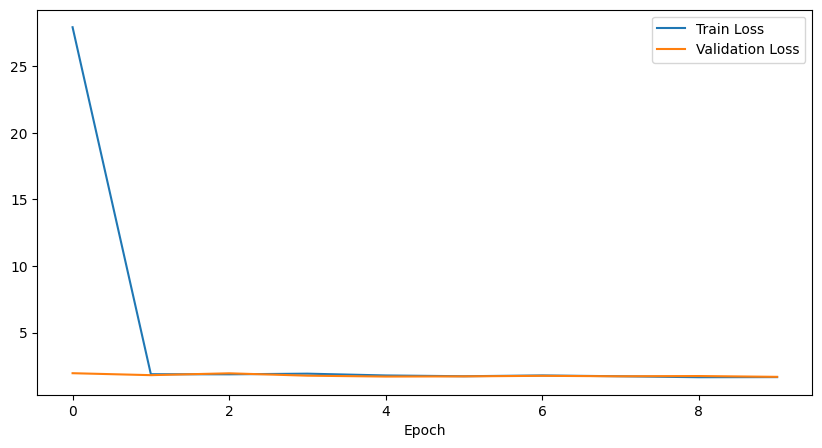

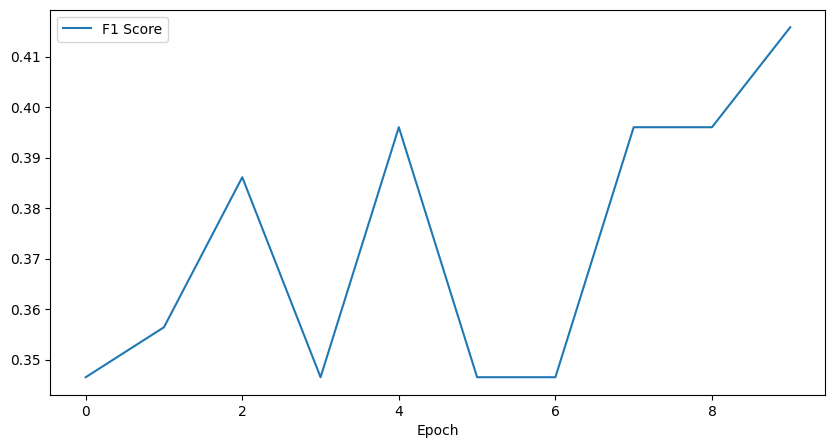

tensor(1.6475)
tensor(0.4359)


(tensor(0.4359), tensor(1.6475))

In [ ]:
set_seed(8059)

trainingset, validationset,testset = get_dataset('watercrafts.train')
train_dataset = ClassificationDataset(trainingset['images'], trainingset['labels'])
valid_dataset = ClassificationDataset(validationset['images'], validationset['labels'])
test_dataset = ClassificationDataset(testset['images'], testset['labels'])

alexnet_model = CustomAlexNet(num_classes=9)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
testset_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
loss_function = get_loss_function()
optimizer = get_optimizer(alexnet_model)
history=train(alexnet_model, train_loader, valid_loader, optimizer, loss_function, 10)

print(history)

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['f1_score'], label='F1 Score')
plt.xlabel('Epoch')
plt.legend()
plt.show()

evaluate(alexnet_model, testset_loader, loss_function)

